# MAST Table Access Protocol Hubble Source Catalog Demo

<br> This tutorial demonstrates how to use astroquery to access the Hubble Source Catalog (HSC) via a Virtual Observatory standard Table Access Protocol (TAP) service at MAST, and work with the resultant data. 

***
### Table of Contents

1. [HSC TAP Service Introduction](#HSC-TAP-Service-Introduction)
2. [Imports](#Imports)
3. [Connecting, Finding, and Displaying Table Information](#Connecting,-Finding,-and-Displaying-Table-Information)
    - [Connecting to a TAP Service](#Connecting-to-a-TAP-Service)
    - [Querying for Table Schema Information](#Querying-for-Table-Schema-Information)
    - [Querying for Data](#Querying-for-Data)
    - [Use Case: Plotting a light curve for the most variable object in a field](#Use-Case:-Plotting-a-light-curve-for-the-most-variable-object-in-a-field)
    - [Use Case: Create a color magnitude diagram for the Small Magellanic Cloud](#Use-Case:-Create-a-color-magnitude-diagram-for-the-Small-Magellanic-Cloud) <br><br>
4. [Additional Resources](#Additional-Resources)
5. [About This Notebook](#About-this-Notebook)
***

## HSC TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns retunred from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by the ESAC Space Data Centre for working with the GAIA catalog, but is interoperable with other valid TAP services, including those at MAST. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html

We'll be using TAP+ to call the most recent version (3) of the Hubble Source Catalog TAP service at MAST. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one available via the CasJobs interface, with an additional view added for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/hcasjobs/



***
## Imports

In [1]:
# Use the astroquery TapPlus library as our client to the data service.
from astroquery.utils.tap.core import TapPlus

## For handling ordinary astropy Tables in responses
from astropy.table import Table

# For displaying and manipulating some types of results
%matplotlib inline
import requests
import astropy
import numpy as np
import time
from matplotlib import pyplot as plt

# To allow display tweaks for wider response tables
from IPython.core.display import display
from IPython.core.display import HTML

# For the second example: kernel density estimates
from scipy.stats import gaussian_kde

***
## Connecting, Finding, and Displaying Table Information 

### Connecting to a TAP Service

The TapPlus library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. This is the URL for the newest version of the Hubble Source Catalog TAP service.

In [2]:
HSC_service = TapPlus(url="http://vao.stsci.edu/HSCTAP/tapservice.aspx")

Created TAP+ (v1.0.1) - Connection:
	Host: vao.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### Querying for Table Schema Information
    
TAP services are self-describing, which means the service itself can be asked for its schema and documentation about it. Since the hubble Source Catalog does not follow a data model described by a standard, this is the best way to see what tables and columns we have available to then query based on geometry or other filters. 
    
The main view for HSC, SumMagAper2CatView, is extremely wide, containing columns for all potential filters, each of which may have null data. So in showing our query results, we will cut off the display with "..." marks. You can change the 'if' line to show the rest of these columns.

In [3]:
HSC_tables = HSC_service.load_tables()
print('\n')
for table in HSC_tables:
    if( table.name == 'dbo.SumMagAper2CatView'):
        print(table)
        print('\n')
        for i, column in enumerate(table.columns):
            #only show the first 30 and last 10 columns
            if i < 30 or i > len(table.columns)-10:
                print(column.name)
            #skip display for the middle column names
            elif i == 30:
                print("...")

Retrieving tables...


Parsing tables...
Done.


TAP Table name: dbo.dbo.SumMagAper2CatView
Description: This table provides Source Extractor magaper2 information for each match based on sources with valid Source Extractor aper2 magnitudes. The companion table SumMagAper2CatViewView  contains other summary information for the corresponding match
Num. columns: 818


MatchID
MatchRA
MatchDec
DSigma
AbsCorr
NumFilters
NumVisits
NumImages
StartTime
StopTime
StartMJD
StopMJD
TargetName
CI
CI_Sigma
KronRadius
KronRadius_Sigma
Extinction
SpectrumFlag
MatchID
W3_BLANK
W3_BLANK_MAD
W3_BLANK_N
W2_F122M
W2_F122M_MAD
W2_F122M_N
W2_F160BN15
W2_F160BN15_MAD
W2_F160BN15_N
W2_F160BW
...
W3_F160W
W3_F160W_MAD
W3_F160W_N
W3_F164N
W3_F164N_MAD
W3_F164N_N
W3_F167N
W3_F167N_MAD
W3_F167N_N


***
### Querying for Data

As noted above, this view contains every filter known in the HSC, and can return each even if it is NULL for the given match (this can cause warnings in astroquery). In order to narrow results, one could query on individual filters where their value is not null, or only return certain of them. 

Here we are searching for every row with data within a .1 degree circle of RA=129.23 and Dec=7.95, and returning a few columns to get an idea of what we have available.

In [4]:
job = HSC_service.launch_job("""
SELECT TOP 10 MatchRA, MatchDec, TargetName, StartTime, StopTime
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  """)
HSC_results = job.get_results()
HSC_results

MatchRA,MatchDec,TargetName,StartTime,StopTime
float64,float64,object,object,object
129.217229657802,7.94543470425575,J083655+075712,12/7/2009 4:10:34 PM,12/7/2009 4:53:36 PM
129.217737714562,7.95414102965508,J083655+075712,12/7/2009 4:10:34 PM,12/7/2009 4:53:36 PM
129.218226395257,8.04148403167514,SDSSJ0837+0801,3/15/2015 2:34:37 PM,3/15/2015 3:07:16 PM
129.207799159392,7.9492882332153,J083655+075712,12/7/2009 4:10:34 PM,12/7/2009 4:53:36 PM
129.233483726636,8.04332727394751,SDSSJ0837+0801,3/15/2015 2:34:37 PM,3/15/2015 3:07:16 PM
129.257510357765,8.02818860818827,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM
129.226400095896,7.99905396481293,SDSSJ0837+0801,3/15/2015 2:34:37 PM,3/15/2015 3:07:16 PM
129.212558909441,8.02896182451976,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM
129.264490548965,8.00118432414167,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM


We can also filter by start/stop time or any other column in the view:

In [5]:
job = HSC_service.launch_job("""
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime, TargetName 
FROM dbo.SumMagAper2CatView
WHERE 
CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
AND StartTime > '2015-01-01' AND StopTime < '2015-04-01'
""")
HSC_results = job.get_results()
HSC_results

MatchID,MatchRA,MatchDec,TargetName,StartTime,StopTime,TargetName1
int64,float64,float64,object,object,object,object
26913472,129.236524508044,8.0190184630211,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 2:55:27 PM,SDSSJ0837+0801
62536502,129.250972355851,7.99846466129993,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
63998279,129.219472431442,8.04765134532228,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
16245848,129.251719817549,8.02903930963134,SDSSJ0837+0801,3/15/2015 2:34:37 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
90208332,129.23932170697,8.00627086903824,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
22432498,129.219041207037,7.99780417497228,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
5761868,129.244156247957,8.0337191340111,SDSSJ0837+0801,3/15/2015 2:34:37 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
79800232,129.261879741025,8.04067640533475,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801
17101696,129.244000859306,8.04660784484708,SDSSJ0837+0801,3/15/2015 2:22:48 PM,3/15/2015 3:07:16 PM,SDSSJ0837+0801


***
### Use Case: Plotting a light curve for the most variable object in a field

A use case example: search for objects with 10 or more ACS F475W magnitudes in a crowded field near IC 1613 (see <a href="http://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html">HSC Use Case 3</a>). Then get the individual A_F475W measurements for the most variable object in the list and plot the light curve. Note we are using asynchronous query mode for this example rather than synchronous, because it has a longer allowed timeout, which can be useful for large or complex queries.

Query finished.


Text(0, 0.5, 'A_F475W_MAD')

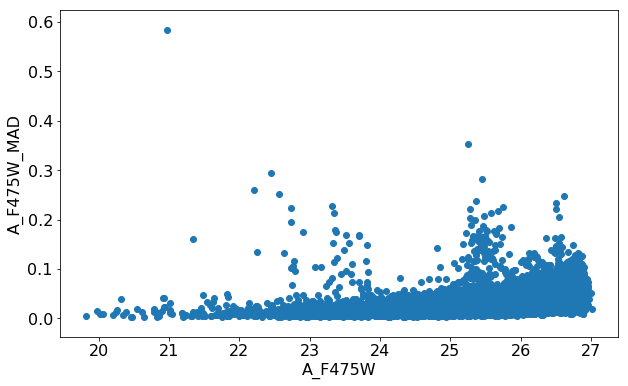

In [6]:
job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   """)
HSC_results = job.get_results()
HSC_results

plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,6))
plt.scatter(HSC_results['A_F475W'], HSC_results['A_F475W_MAD'])
plt.xlabel('A_F475W')
plt.ylabel('A_F475W_MAD')


 MatchID      MatchRA          MatchDec     TargetName NumImages NumVisits     A_F475W         A_F475W_MAD    A_F475W_N
--------- ---------------- ---------------- ---------- --------- --------- ---------------- ----------------- ---------
102334412 16.1300038988983 2.16551528221144     IC1613        26        14 20.9708499908447 0.584400177001953        12


Query finished.


Text(0, 0.5, 'A_F475W')

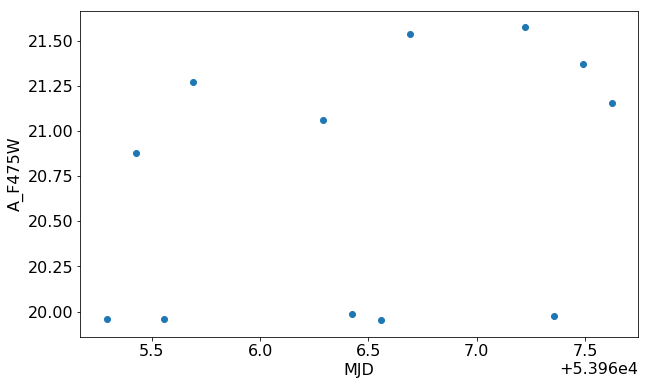

In [7]:
madvalues = HSC_results['A_F475W_MAD']
i = np.argmax(madvalues)
print()
print(HSC_results[i])

matchid = HSC_results['MatchID'][i]
job = HSC_service.launch_job_async("""
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID={}
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
""".format(matchid))
HSC_details = job.get_results()
HSC_details

plt.rcParams.update({'font.size': 16})
plt.figure(1,(10,6))
plt.scatter(HSC_details['StartMJD'], HSC_details['MagAper2'])
plt.xlabel('MJD')
plt.ylabel('A_F475W')

***
### Use Case: Create a color magnitude diagram for the Small Magellanic Cloud

For another example of using data from a TAP service, we start by doing a search around the SMC with a .25 degree radius for objects with ACS F555W and F814W measurements. HSC TAP will limit us to 100k responses by default. Note this is a large query that can take over a minute to run. See <a href="http://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html" target="_blank">HSC Use Case 2</a> for more details.

In [8]:
t0 = time.time()

job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.25))=1
   """)
HSC_results = job.get_results()
print("Query completed in {:.1f} sec".format(time.time()-t0))
HSC_results

Query finished.
Query completed in 43.7 sec


MatchID,MatchRA,MatchDec,CI,A_F555W,A_F814W
int64,float64,float64,float64,float64,float64
78599164,13.0053099571552,-72.9602510429956,1.055802496863,21.9405002593994,21.7588996887207
24160045,13.8427775457798,-72.8519041649433,1.03120373355018,23.3551998138428,23.2070007324219
33313821,12.4487959933535,-72.8762351476651,1.15712963872486,22.3878993988037,23.0739994049072
40012744,13.0740790838097,-72.9753342566277,0.913302490004787,24.0475997924805,23.8059997558594
103954921,12.9013589010001,-72.9674510870669,1.59691362469285,22.6056995391846,22.3271007537842
73260058,13.9041065889472,-72.840060053653,0.986712950247305,22.3150997161865,22.24049949646
8133730,13.1498960615587,-73.0642717890387,1.13419750590383,23.4916000366211,23.3812999725342
71293113,12.9507131584755,-72.9482611640678,0.920092581230917,24.3031005859375,23.9818000793457
83389072,14.0212655585113,-72.8395635121378,0.86481480134858,24.8159999847412,24.5823001861572


Next, plot the color-magnitude diagram for the ~100k points retrieved from the database. This uses kernel density estimate for the crowded plot. As a preview for the demo, we are only working with 1/25th of the data so that the notebook executes quickly. You can switch the commented-out lines to call gaussian_kde for the full plot, which can take a few minutes to complete.

In [9]:
f555w = HSC_results['A_F555W']
f814w = HSC_results['A_F814W']
VminusI = f555w-f814w
CI = HSC_results['CI']
w = np.where((CI>0.9) & (CI<1.6) & (VminusI > -1.5) & (VminusI < 1.5))
print(len(w[0]),"points remaining after CI and V-I filtering")

# Calculate the point density
x = np.array(VminusI[w])
y = np.array(f555w[w])
xy = np.vstack([x,y])

t0 = time.time()

z = gaussian_kde(xy[:, ::25])(xy) #to do the KDE on only the full dataset, comment out this and uncomment below:
#z = gaussian_kde(xy)(xy) #uncomment this line to do the KDE on the full dataset

print("kde took {:.1f} sec".format(time.time()-t0))

88243 points remaining after CI and V-I filtering


kde took 3.3 sec


Text(0.17, 0.93, '88243 stars in SMC')

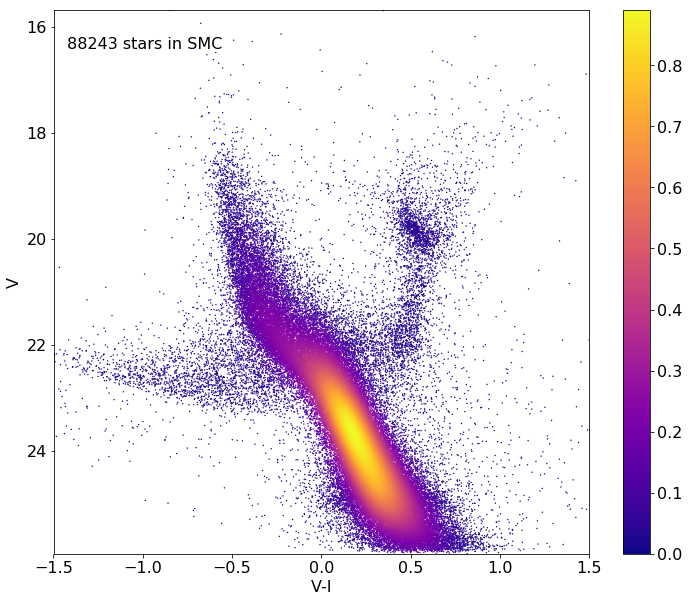

In [10]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.rcParams.update({'font.size': 16})
plt.figure(1,(12,10))
plt.scatter(x, y, c=z, s=2, edgecolor='', cmap='plasma')
plt.autoscale(tight=True)
plt.xlabel('V-I')
plt.ylabel('V')
plt.gca().invert_yaxis()
plt.colorbar()
plt.text(.17,.93,'{:d} stars in SMC'.format(len(x)),
       horizontalalignment='center',
       transform=plt.gca().transAxes)
#plt.savefig("smc_colormag.png")

***
# Additional Resources


## Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

## Hubble Source Catalog v3
* Catalog created at MAST by combining the tens of thousands of visit-based source lists in the Hubble Legacy Archive (HLA) into a single master catalog. 
* https://archive.stsci.edu/hst/hsc/

## Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

## TapPlus 
* Module created by ESAC Space Data Centre
* http://astroquery.readthedocs.io/en/latest/utils/tap.html

***

## About this Notebook
**Authors:** Rick White & Theresa Dower, STScI Archive Scientist & Software Engineer
**Updated On:** 11/23/2018

***

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 